# **Proyek Klasifikasi Gambar: Klasifikasi Gambar Satellite**



*   Nama: Muhammad Iqbal
*   Email: eqbalahmed3072@gmail.com
*   ID Dicoding: muhammad_iqbal_MVtE




## **Objective**:

Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan gambar yang di peroleh dari satellite remote sensing

## **Sumber Dataset**

https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

# Import Library

In [1]:
# Importing the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from google.colab import files
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img # ImageDataGenerator has been removed from this module
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LSTM, TimeDistributed, GlobalMaxPooling2D
from keras.models import load_model,Model,Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator from tensorflow.keras.preprocessing.image
import cv2

# Data Preparation

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadiqbal92","key":"e13e24c5a77b2c964cd0a7ae7214d92d"}'}

# Data Loading

In [3]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mahmoudreda55/satellite-image-classification
!unzip satellite-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  infl

# Data Preprocessing


## Split Dataset

In [4]:
!pip install split-folders
import splitfolders
splitfolders.ratio('data', output="/data/splitted", seed=1337, ratio=(0.8, 0.2))

Copying files: 5631 files [00:00, 8527.65 files/s]


In [5]:
# Define Dir Dataset
train_directory = '/content/splitted/train'
val_directory = '/content/splitted/val'

In [6]:
# Variable
batch_size = 32
epochs = 10
img_rows = 224
img_cols = 224
color_type = 3
num_classes=7
num_sequence=8
accuracy_threshold = 0.95

data  drive  kaggle.json  sample_data  satellite-image-classification.zip
/content/splitted/train
cloudy	desert	green_area  water


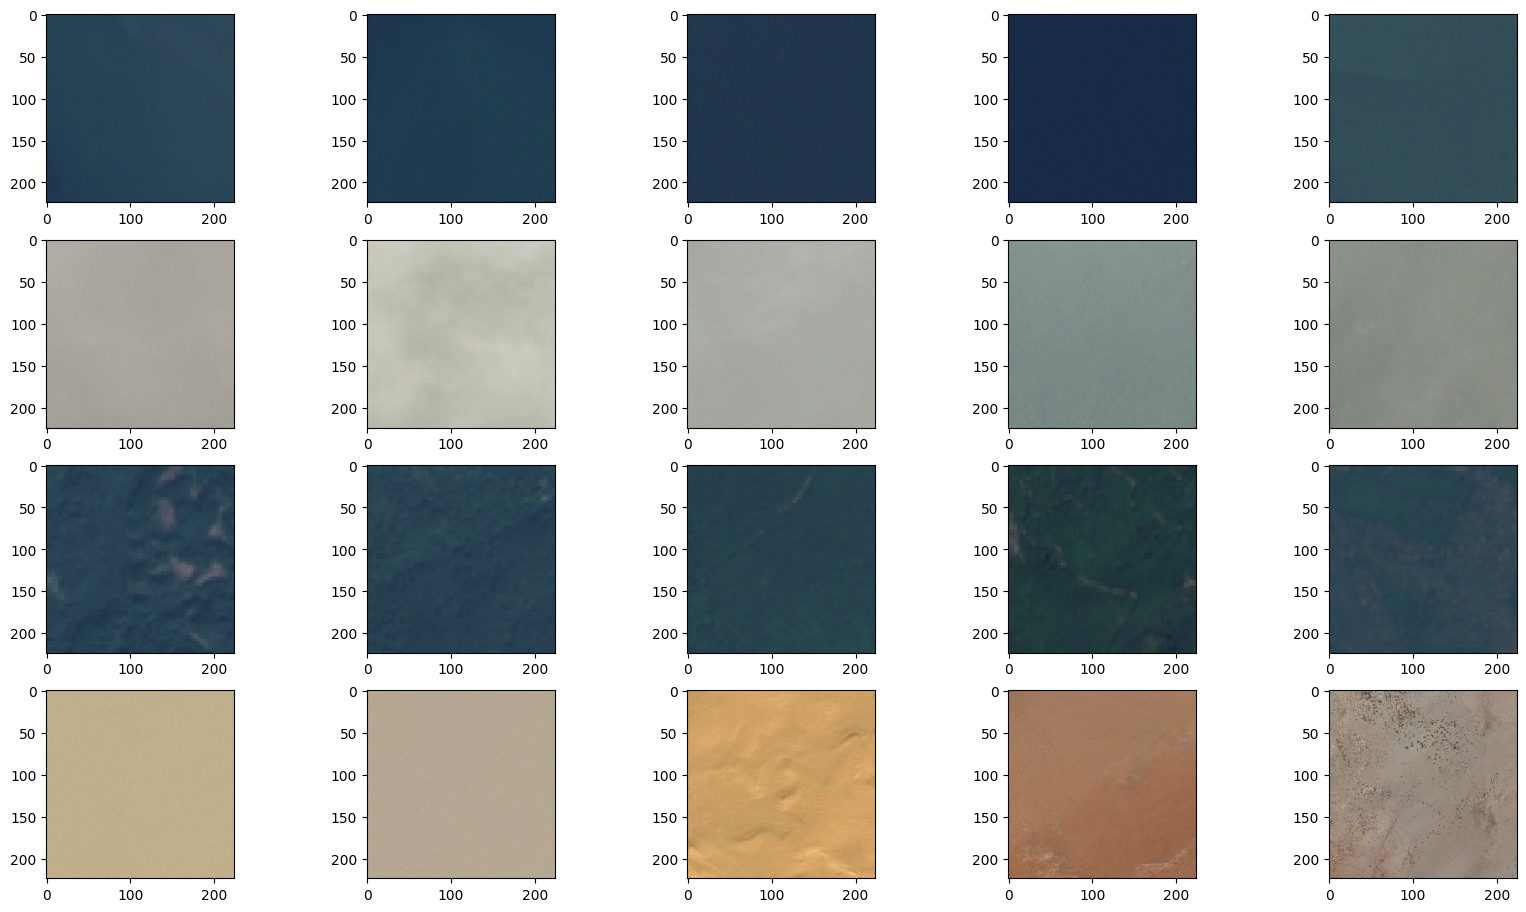

In [7]:
# Import the os module
import os

# List the current directory contents to check if 'splitted' directory exists
!ls

# Print the value of train_directory to double check the path
print(train_directory)

# If the directory does not exist, check the output path in splitfolders.ratio
# and update train_directory with the correct path
train_directory = '/data/splitted/train'

# Now try to list the contents of the train_directory
!ls {train_directory}

# Proceed with the rest of your code if the directory exists
plt.figure(0, figsize=(20, 20))
pict = 0
for expression in os.listdir(train_directory):
    for i in range(1, 6):
        pict = pict + 1
        plt.subplot(7, 5, pict)
        img = load_img(train_directory + '/' + expression + '/' +os.listdir(train_directory + '/' + expression)[i], target_size=(img_rows, img_cols))
        plt.imshow(img, cmap="gray")
plt.show()

In [8]:
# Define Dir Dataset
train_directory = '/data/splitted/train' # Changed directory path to match output from splitfolders.ratio
val_directory = '/data/splitted/val' # Changed directory path to match output from splitfolders.ratio

In [9]:
# Show the classes
classes = os.listdir(train_directory)
classes

['water', 'cloudy', 'green_area', 'desert']

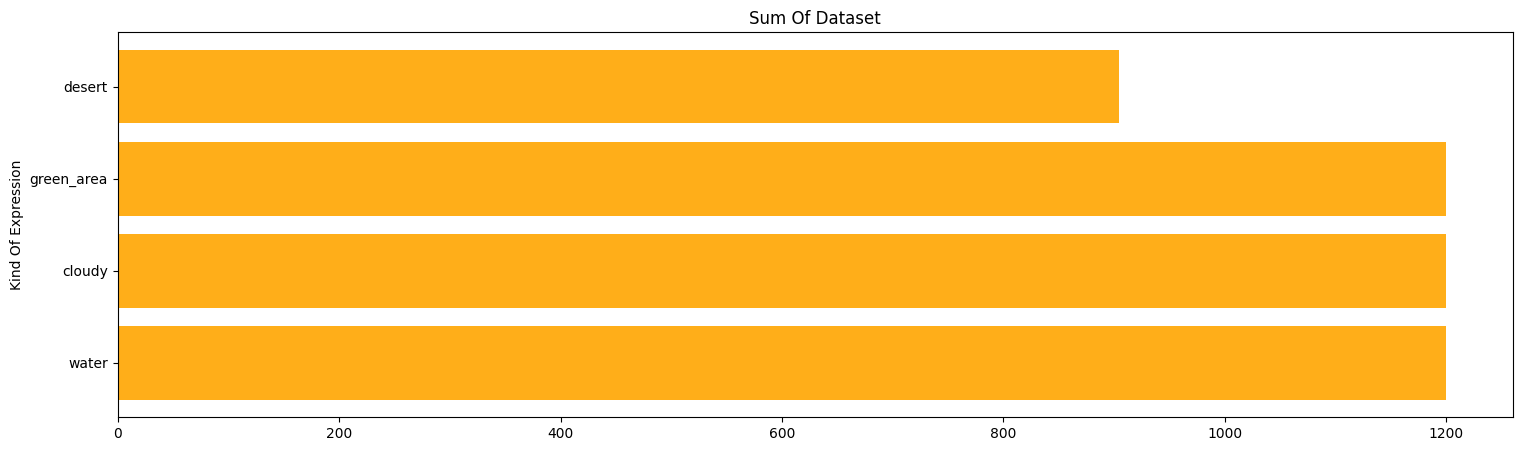

In [10]:
# Show frequency data each class in training dataset
plt.figure(figsize=(18, 5))

# Calculate the sum of images for each class
sum_of_images = [len(os.listdir(os.path.join(train_directory, expression))) for expression in classes]

plt.barh(classes, sum_of_images, color='orange', alpha=0.9)
plt.ylabel('Kind Of Expression')
plt.title('Sum Of Dataset')
plt.show()

In [11]:
#Data Augmentation
train_datagen= ImageDataGenerator(rescale = 1.0/255.0,
                                horizontal_flip=True,
                                rotation_range=20,
                                shear_range=0.2)

val_datagen = ImageDataGenerator(rescale= 1.0/255)

train_dataset = train_datagen.flow_from_directory(train_directory,
                                                target_size=(img_rows,img_cols),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

val_dataset = val_datagen.flow_from_directory(val_directory,
                                           target_size=(img_rows,img_cols),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

# Load pre-trained MobileNetV2 model without top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, color_type))

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

Found 4504 images belonging to 4 classes.
Found 1127 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Show Image Shape

(224, 224, 3)
(1, 224, 224, 3)


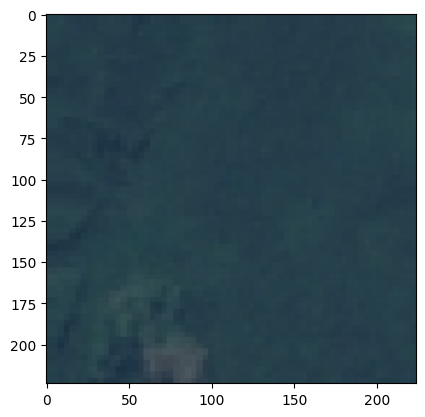

In [12]:
# Show Image Shape
pict = image.load_img("/content/data/green_area/Forest_1404.jpg", target_size=(img_rows,img_cols))
pict = np.array(pict)
plt.imshow(pict)
print(pict.shape)

pict = np.expand_dims(pict, axis=0)
print(pict.shape)

# Modelling

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# My Callback
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > accuracy_threshold):
			print("\n Got %2.2f%% accuracy, stop model training" %(accuracy_threshold*100))
			self.model.stop_training = True

model_check_point_callback = myCallback()

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', patience=15,
                                                  restore_best_weights=True)

In [16]:
# Run CNN Model
steps_per_epoch = train_dataset.samples // train_dataset.batch_size
validation_steps = val_dataset.samples // val_dataset.batch_size

# Set num_classes to 4
num_classes = 4

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # Set the number of classes in the output layer to 4

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

modelHistory = model.fit(train_dataset,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data = val_dataset,
                            shuffle=True,
                            verbose=1,
                            callbacks=[model_check_point_callback, earlyStopping],
                            validation_steps=validation_steps)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 62s 382ms/step - accuracy: 0.6828 - loss: 0.7172 - val_accuracy: 0.8107 - val_loss: 0.4627
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 78s 359ms/step - accuracy: 0.8332 - loss: 0.3825 - val_accuracy: 0.8571 - val_loss: 0.2464
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 370ms/step - accuracy: 0.8569 - loss: 0.3277 - val_accuracy: 0.8455 - val_loss: 0.4342
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8510 - loss: 0.3649 - val_accuracy: 1.0000 - val_loss: 0.1421
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 361ms/step - accuracy: 0.8685 - loss: 0.3070 - val_accuracy: 0.8482 - val_loss: 0.3208
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 140s 778ms/step - accuracy: 0.8783 - loss: 0.2743 - val_accuracy: 0.8571 - val_loss: 0.2834
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 85s 372ms/step - accuracy: 0.9019 - loss: 0.2563 - val_accuracy: 0.8955 - val_loss: 0.2978
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 558ms/step - accuracy: 0.8827 - loss: 

# Evaluasi dan Visualisasi

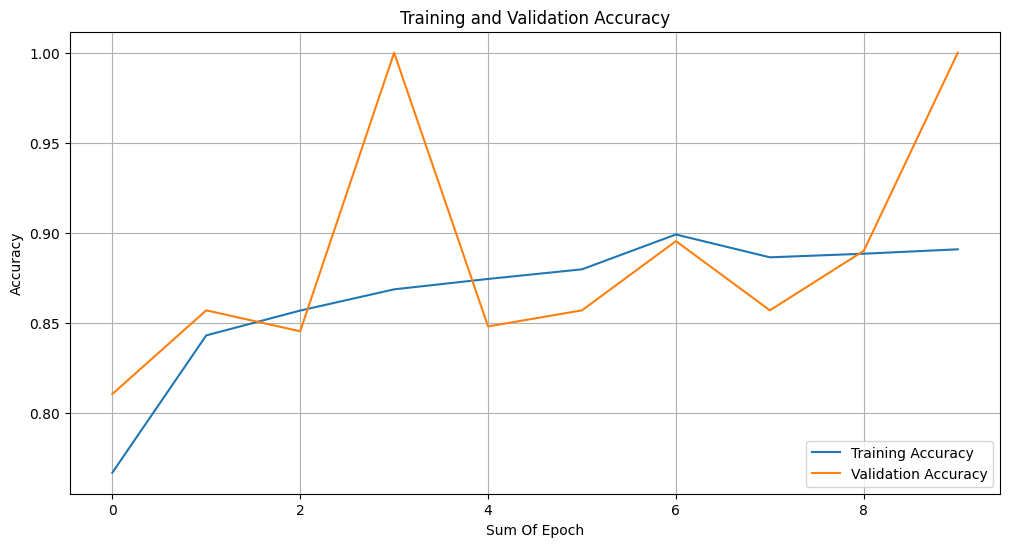

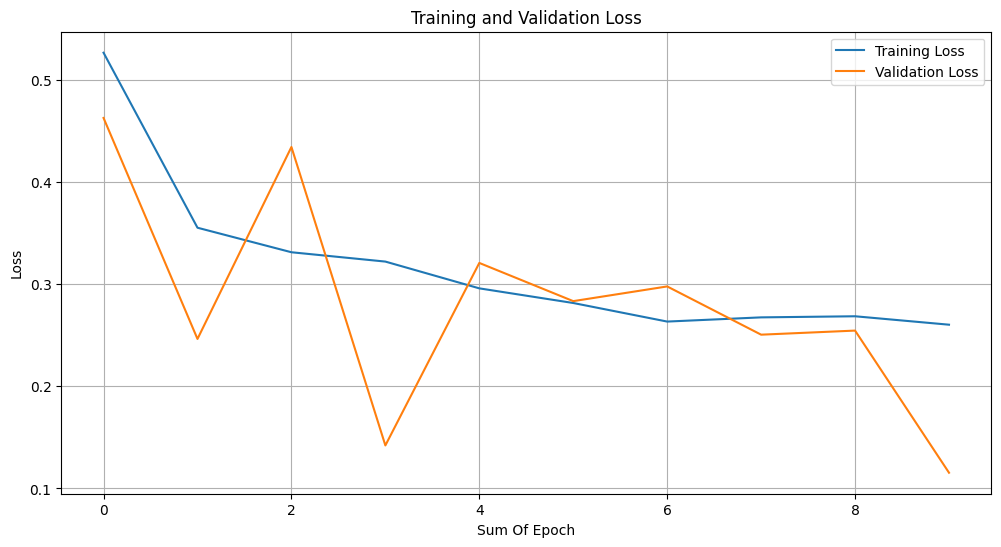

In [17]:
# Plot Training & Validation Accuracy Values
plt.figure(figsize=(12, 6))
plt.plot(modelHistory.history['accuracy'])
plt.plot(modelHistory.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Sum Of Epoch')
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot Training & Validation Loss Values
plt.figure(figsize=(12, 6))
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Sum Of Epoch')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [18]:
# Evaluate
evaluate = model.evaluate(val_dataset, verbose=1)
print('Loss: ', evaluate[0])
print('Accuracy: ', evaluate[1]*100, '%')

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9174 - loss: 0.2341
Loss:  0.29675403237342834
Accuracy:  89.61845636367798 %


# Konversi Model

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


<Figure size 640x480 with 0 Axes>

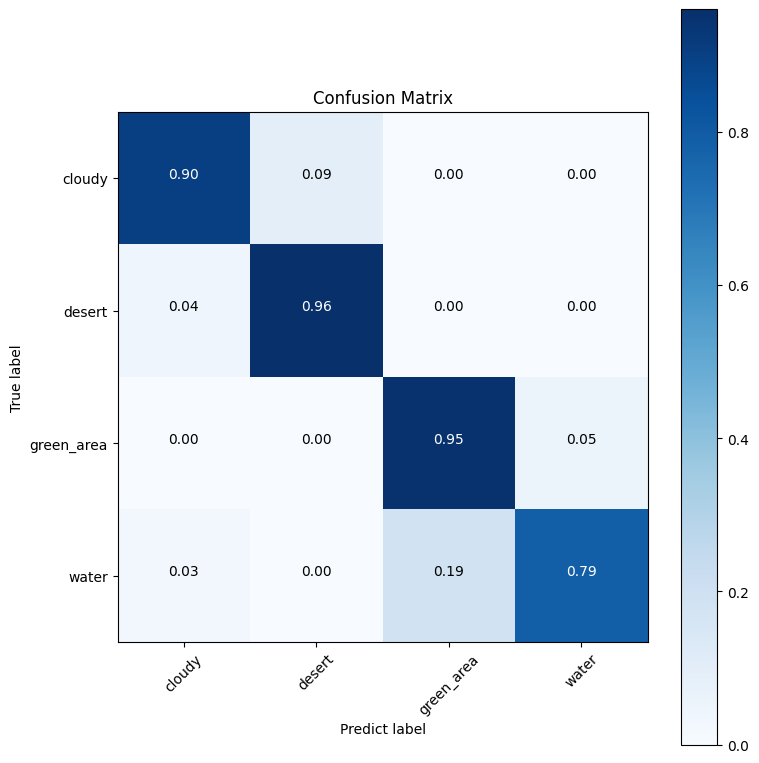


 Classification Report
              precision    recall  f1-score   support

      cloudy       0.94      0.90      0.92       300
      desert       0.89      0.96      0.92       227
  green_area       0.83      0.95      0.89       300
       water       0.94      0.79      0.86       300

    accuracy                           0.90      1127
   macro avg       0.90      0.90      0.90      1127
weighted avg       0.90      0.90      0.90      1127



In [19]:
# Confusion Matrix
predictGenerator = model.predict(val_dataset)
yPred = [np.argmax(probas) for probas in predictGenerator]
yTest = val_dataset.classes
classNames = val_dataset.class_indices.keys()

def chartConfusionMatrix(confMatrix, classes, title, cmap=plt.cm.Blues):
    confMatrix = confMatrix.astype('float') / confMatrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    plt.imshow(confMatrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tickMark = np.arange(len(classes))
    plt.xticks(tickMark, classes, rotation=45)
    plt.yticks(tickMark, classes)

    formatNumber = '.2f'
    threshold = confMatrix.max() / 2.
    for i, j in itertools.product(range(confMatrix.shape[0]), range(confMatrix.shape[1])):
        plt.text(j, i, format(confMatrix[i, j], formatNumber),
                 horizontalalignment="center",
                 color="white" if confMatrix[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.tight_layout()

confMatrix = confusion_matrix(yTest, yPred)
np.set_printoptions(precision=2)

plt.figure()
chartConfusionMatrix(confMatrix, classes=classNames, title='Confusion Matrix')
plt.show()

print('\n Classification Report')
targetNames = list(classNames)
print(classification_report(val_dataset.classes, yPred, target_names=targetNames))

In [20]:
#save model
save_path_model = "/content/model/"
tf.saved_model.save(model, save_path_model)

In [21]:
import os
# Buat fungsi untuk konversi model ke TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enable resource variables
converter.experimental_enable_resource_variables = True
# Use Select TF ops and disable _experimental_lower_tensor_list_ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Simpan model TFLite ke file
tflite_save_path = 'content/my_model_tflite/my_model.tflite'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(tflite_save_path), exist_ok=True)

with open(tflite_save_path, 'wb') as f:
  f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite")

Saved artifact at '/tmp/tmpvg5pnbo3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_250')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133220493536320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220357545248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219959254080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219959256368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219959392560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219959395552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219959400656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219959404176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219959404704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219959405232: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhas

In [22]:
!pip install tensorflowjs
# Konversi model SavedModel ke format TFJS menggunakan tensorflowjs_converter
!tensorflowjs_converter --input_format=tf_saved_model \
"/content/model" \
"/content/my_model_tfjs"

print("Model berhasil dikonversi ke format TFJS")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 119.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
2024-09-19 09:11:49.090439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 09:11:49.109900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 09:11:49.116654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to r

In [23]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 87%)
  adding: content/model/fingerprint.pb (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 62%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: content/model/assets/ (stored 0%)


In [24]:
!zip -r /content/content/my_model_tflite.zip /content/content/my_model_tflite

  adding: content/content/my_model_tflite/ (stored 0%)
  adding: content/content/my_model_tflite/my_model.tflite (deflated 16%)


In [25]:
!zip -r /content/my_model_tfjs .zip /content/my_model_tfjs

	zip warning: name not matched: .zip
  adding: content/my_model_tfjs/ (stored 0%)
  adding: content/my_model_tfjs/group1-shard1of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard6of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard5of11.bin (deflated 7%)
  adding: content/my_model_tfjs/model.json (deflated 88%)
  adding: content/my_model_tfjs/group1-shard3of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard10of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard2of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard11of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard4of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard9of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard7of11.bin (deflated 7%)
  adding: content/my_model_tfjs/group1-shard8of11.bin (deflated 7%)


In [26]:
!pip freeze > requirements.txt